## Calculating likelihoods

In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time

from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs

from sample import sample

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [2]:
params = ['mchirp','q', 'chieff', 'z']
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

model_names, flow = read_models.get_models(file_path, ['CE'], params, use_flows=True, device='cpu')
_, KDE = read_models.get_models(file_path, ['CE'], params, use_flows=False, device='cpu')

100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


## Likelihoods In sampling

In [3]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [4]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/flow_models/cosmo_weights/"
flow['CE'].load_model(flow_path, 'CE')

In [12]:
for i in range(46):
    print(np.array(obsdata[i,:,0]<flow['CE'].mappings[1]))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True 

In [14]:
obsdata[-7,:,:]

array([[ 6.24189685e+01,  6.16166970e-01,  4.80720591e-02,
         8.20151503e-01],
       [ 5.74154958e+01,  6.94578815e-01, -1.82948972e-01,
         7.27367960e-01],
       [ 6.62561654e+01,  6.80112068e-01, -2.45361359e-01,
         6.64487141e-01],
       [ 6.49710038e+01,  7.32136017e-01,  1.17432054e-01,
         7.34766853e-01],
       [ 7.00543816e+01,  8.61702050e-01, -5.35952430e-02,
         6.87380456e-01],
       [ 6.29509795e+01,  5.94433888e-01,  7.57718561e-02,
         9.13327178e-01],
       [ 6.72253200e+01,  7.29935749e-01, -2.44580075e-01,
         6.55203352e-01],
       [ 5.91119110e+01,  8.78997415e-01, -5.39025150e-02,
         9.94145471e-01],
       [ 6.62648718e+01,  9.70522043e-01,  1.12666680e-01,
         8.34465561e-01],
       [ 6.18768776e+01,  8.25816747e-01,  1.62475189e-01,
         9.17108561e-01],
       [ 6.64624535e+01,  8.01288197e-01,  4.47704081e-01,
         9.81620535e-01],
       [ 6.38888832e+01,  8.95362505e-01, -2.40722392e-01,
      

In [18]:
flow['CE'].mappings

array([8.232875920000927, 37.6363925625166, 13.347090269689224, None,
       6.907754476512362, 10.009991975305043], dtype=object)

In [13]:
lnlike_flow=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        lnlike_flow[chibid,alphaid]=sample.lnlike([chibid,alphaid],obsdata, flow, submodels_dict, ['CE'], use_flows=True)

nans!
[[ -0.64694214  -5.50950813 -23.27304268 ...   0.11374521  -1.40273476
   -2.35862494]
 [ -5.88798141  -9.52690411 -11.84192562 ...  -3.83143997  -6.11886597
   -5.35567713]
 [ -7.0043745   -7.69023132  -3.6651926  ...  -6.99290609  -2.5589695
   -0.40786648]
 ...
 [-16.46439171 -14.70272827 -15.25437164 ... -14.00688744 -15.25451851
  -11.76208019]
 [-19.7650528   -9.1372118   -8.59518147 ...   0.7707777   -4.26047516
   -3.069417  ]
 [-13.64846802  -6.14637756  -3.90932369 ...  -1.68021107 -12.29621124
   -6.40632963]]
[  3.37246839   0.97480372   1.57609504   0.91889091 -14.18442007
   4.56789709   2.66534751 -17.33405685 -17.74626923   6.37157852
   4.35798394   3.64590463   5.0988697   -1.0083866    3.29814859
   0.66060487   4.16628378   4.23880508   3.47862116   4.03640828
   2.87110581   4.70970265   5.76682339   3.32789364   5.24664649
   5.66715639   1.29320763  -1.1527551    1.5647891    4.2794953
   4.1617711    2.7128269    0.70705222   6.59025031   3.9562555
   1.16

In [6]:
lnlike_flow

array([[-127.12405803, -144.23840373, -134.19877746, -138.82112133,
        -170.23952599],
       [-140.61459926, -152.65872491, -140.40912039, -142.67751672,
        -169.21367052],
       [-206.39783624, -216.46209784, -206.19647045, -209.98646548,
        -251.91902876],
       [-595.39372515, -623.18543154, -610.75429832, -552.8037186 ,
        -451.82079771]])

Text(0.5, 1.0, 'CE channel likelihoods (flow)')

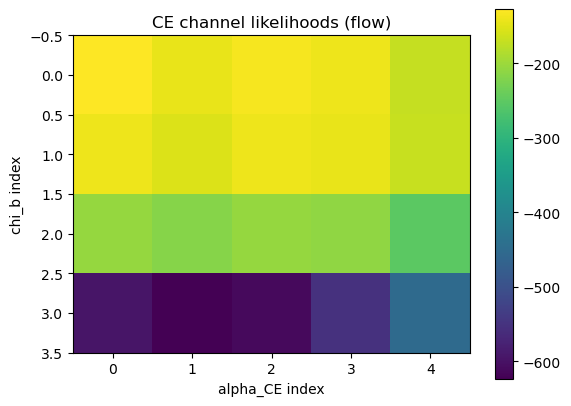

In [12]:
plt.imshow(lnlike_flow)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (flow)')

In [29]:
flow['CE'].mappings[1]=100.

In [33]:
test_sample = np.array([[[10.,0.5,0.03,0.1],[10.,0.5,0.03,0.1]]])
mapped_sample = flow['CE'].map_obs(test_sample)
test_conditional=np.array([[[0.1,0.5],[0.1,0.5]]])
test_conditional_inxs = np.array([[[1,1]]])

In [34]:
mapped_sample

array([[[-0.26688421,  0.        ,  0.029991  , -0.66535784],
        [-0.26688421,  0.        ,  0.029991  , -0.66535784]]])

In [35]:
flow['CE'].flow.get_logprob(mapped_sample,test_conditional)

array([[-8.552598, -8.55259 ]], dtype=float32)

In [17]:
np.log(KDE['CE']['chi01']['alpha05'].pdf(obsdata[-7,:,:]))

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_74722/892537039.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(KDE['CE']['chi01']['alpha05'].pdf(obsdata[-7,:,:]))


array([-619.07598063, -507.96408628,          -inf, -610.80867435,
                -inf, -658.80586736,          -inf, -370.18123883,
       -545.82509091, -445.39889781, -613.91187536, -651.7295184 ,
       -642.83020158,          -inf, -736.09129738,          -inf,
       -734.29756747,          -inf, -485.03869717,          -inf,
                -inf,          -inf, -657.57005107,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf, -689.37711163, -486.57389267, -543.16316876,
       -603.83272203,          -inf, -544.07938555,          -inf,
                -inf, -470.64020531,          -inf,          -inf,
                -inf,          -inf,          -inf, -487.47780788,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf, -567.69324509, -423.79514423,
                -inf, -571.97167349,          -inf, -374.69604911,
                -inf, -714.61308375,          -inf, -666.24844

In [18]:
from functools import reduce
import operator
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

In [8]:
lnlike_kde=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        lnlike_kde[chibid,alphaid]=sample.lnlike([chibid,alphaid,1.],obsdata, KDE, submodels_dict, ['CE'], use_flows=False)

['CE', 'chi00', 'alpha02']
1.0
0.0
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf]
[2.56517013e-03 9.57339440e-04 2.04189627e-03 5.97370864e-04
 1.30881890e-06 9.97676828e-04 2.25321117e-04 2.90513956e-19
 8.44569018e-06 3.70976316e-03 6.25580970e-04 1.15266243e-03
 1.79879578e-03 1.29644192e-04 1.22479564e-03 4.39814303e-04
 7.37576493e-04 1.84211706e-03 2.76904710e-02 8.21421678e-04
 1.03007113e-03 3.95796739e-04 4.18311326e-03 1.91931238e-02
 7.41726057e-04 2.96271225e-03 2.10807336e-05 1.36417313e-04
 1.75394269e-04 1.55427428e-03 3.93878213e-03 1.10706202e-03
 1.50945724e-03 3.29745043e-02 7.00538159e-04 6.03854243e-04
 1.48881486e-03 9.94733895e-08 3.84059209e-02 1.00000000e-50
 6.41952899e-04 3.34538753e-04 2.41461653e-02 1.09707441e-10
 2.07496872e-03 2.72256801e-04]
[  -5.96573047   -6.9513525

In [14]:
lnlike_kde = np.load('CE_lnlike_kde.npy')

Text(0.5, 1.0, 'CE channel likelihoods (KDEs)')

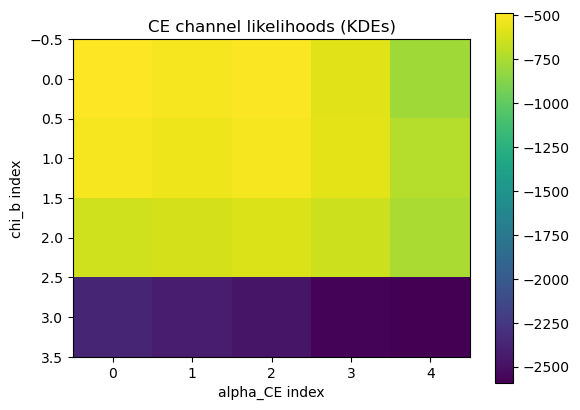

In [21]:
plt.imshow(lnlike_kde)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (KDEs)')

In [15]:
lnlike_kde

array([[ -488.54896481,  -516.01045514,  -497.21744547,  -580.29421382,
         -786.29323308],
       [ -517.44113865,  -539.3906847 ,  -521.00342875,  -575.61471784,
         -720.9136174 ],
       [ -638.6766879 ,  -624.86668284,  -599.60617914,  -649.87875854,
         -752.67508215],
       [-2372.87555011, -2421.31486477, -2474.83763468, -2571.90109638,
        -2591.77152278]])